# Build a DNN using the Keras Functional API

**Learning objectives**

1. Review how to read in CSV files data using `tf.data`
2. Specify input, hidden, and output layers in the DNN architecture
3. Review and visualise the final DNN shape
4. Train the model locally and visualise the loss curves
5. Deploy and predict with the model using Cloud AI Platform

In this notebook, we will build a Keras DNN to predict the fare amount for NYC taxi cab rides.

In [6]:
import os
import json
import math

import numpy as np
import tensorflow as tf

import shutil
print("TensorFlow version:", tf.__version__)

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3" # Set tf error log verbosity

TensorFlow version: 2.4.1


## Locating the CSV files

In [7]:
!ls -l data/taxi*

-rw-r--r-- 1 antounes antounes 123589 avril  9 16:20 data/taxi-test.csv
-rw-r--r-- 1 antounes antounes 579054 avril  9 16:20 data/taxi-train.csv
-rw-rw-r-- 1 antounes antounes 123113 avril  9 16:20 data/taxi-valid.csv


## Use `tf.data` to read the CSV files

First let's define our columns of data, which column we're predicting for, and the default values.

In [8]:
# Define columns of data
CSV_COLUMNS = ["fare_amount", 
               "pickup_datetime", 
               "pickup_longitude", 
               "pickup_latitude",
               "dropoff_longitude", 
               "dropoff_latitude", 
               "passenger_count", 
               "key"]
LABEL_COLUMN = "fare_amount"
DEFAULTS = [[0.0], ["na"], [0.0], [0.0], [0.0], [0.0], [0.0], ["na"]]

Next, let's define the features we want to use and our label(s), then load in the data set for training.

In [18]:
# Define features you want to use
def features_and_labels(row_data):
    for unwanted_col in ["pickup_datetime", "key"]:
        row_data.pop(unwanted_col)
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label # Features, label

# Load the training data
def load_dataset(pattern, batch_size=1, mode=tf.estimator.ModeKeys.EVAL):
    dataset = (tf.data.experimental.make_csv_dataset(pattern, batch_size, CSV_COLUMNS, DEFAULTS)
               .map(features_and_labels) # Features, label
              )
    if mode == tf.estimator.ModeKeys.TRAIN:
        dataset = dataset.shuffle(1000).repeat()
    dataset = dataset.prefetch(1) # Take advantage of multi-threading; 1=AUTOTUNE
    return dataset

## Build a DNN with Keras

Now let's build the Deep Neural Network (DNN) model in Keras and specify the input and hidden layers. We will print out the DNN architecture and visualise it.

In [12]:
# Build a simple Keras DNN using its Functional API
def rmse(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_pred - y_true)))

def build_dnn_model():
    INPUT_COLS = ["pickup_longitude", 
                  "pickup_latitude",
                  "dropoff_longitude", 
                  "dropoff_latitude",
                  "passenger_count"]
    
    # Input layer
    inputs = {
        colname: tf.keras.layers.Input(name=colname, shape=(), dtype="float32")
        for colname in INPUT_COLS
    }
    
    # `tf.feature_column.numeric_column()` represents real valued or numerical features
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in INPUT_COLS
    }
    
    # The constructor for DenseFeatures takes a list of numeric columns
    # The Functional API in Keras requires that you specify LayerConstructor()(inputs)
    dnn_inputs = tf.keras.layers.DenseFeatures(feature_columns.values())(inputs)
    
    # Two hidden layers of [32, 8]
    h1 = tf.keras.layers.Dense(32, activation="relu", name="h1")(dnn_inputs)
    h2 = tf.keras.layers.Dense(8, activation="relu", name="h2")(h1)
    
    # Final output is a linear activation because this is regression
    output = tf.keras.layers.Dense(1, activation="linear", name="fare")(h2)
    model = tf.keras.models.Model(inputs, output)
    model.compile(optimizer="adam", loss="mse", metrics=[rmse, "mse"])
    return model

print("Here is our DNN architecture so far: \n")
model = build_dnn_model()
print(model.summary())

Here is our DNN architecture so far: 

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dropoff_latitude (InputLayer)   [(None,)]            0                                            
__________________________________________________________________________________________________
dropoff_longitude (InputLayer)  [(None,)]            0                                            
__________________________________________________________________________________________________
passenger_count (InputLayer)    [(None,)]            0                                            
__________________________________________________________________________________________________
pickup_latitude (InputLayer)    [(None,)]            0                                            
_____________________________________________________

## Visualise the DNN

We can visualise the DNN using the Keras [plot_model](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/utils/plot_model) utility.

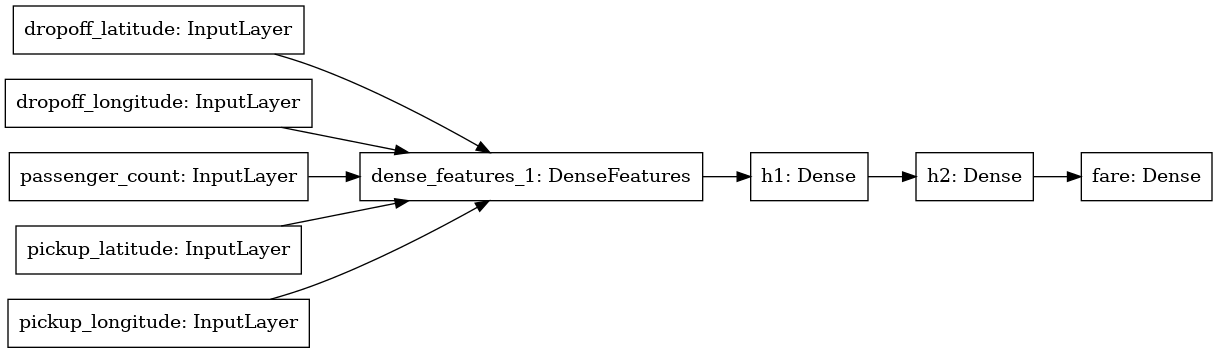

In [13]:
# `tf.keras.utils.plot_model()` converts a Keras model to dot format and saves it to a file
tf.keras.utils.plot_model(model, "dnn_model.png", show_shapes=False, rankdir="LR")

## Train the model

To train the model, simply call [model.fit()](https://keras.io/models/model/#fit)

Note that we should really use many more `NUM_TRAIN_EXAMPLES` (i.e. a larger data set). We shouldn't make assumptions about the quality of the model based on training/evaluating it on a small sample of the full data.

In [19]:
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = 10000 * 5 # Training data set repeats, so it will wrap around
NUM_EVALS = 32 # How many times to evaluate
NUM_EVAL_EXAMPLES = 10000 # Enough to get a reasonable sample, but not so much that it slows down

trainds = load_dataset("data/taxi-train*", TRAIN_BATCH_SIZE, mode=tf.estimator.ModeKeys.TRAIN)
evalds = load_dataset("data/taxi-valid*", 1000, tf.estimator.ModeKeys.EVAL).take(NUM_EVAL_EXAMPLES//1000)

steps_per_epoch = NUM_TRAIN_EXAMPLES//(TRAIN_BATCH_SIZE * NUM_EVALS)

# Model fit
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EVALS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/32
48/48 [==============================] - 2s 18ms/step - loss: 353.8535 - rmse: 17.4897 - mse: 353.8535 - val_loss: 111.8720 - val_rmse: 10.5550 - val_mse: 111.8720
Epoch 2/32
48/48 [==============================] - 1s 16ms/step - loss: 72.8846 - rmse: 8.1634 - mse: 72.8846 - val_loss: 108.9874 - val_rmse: 10.4323 - val_mse: 108.9874
Epoch 3/32
48/48 [==============================] - 0s 10ms/step - loss: 90.9000 - rmse: 9.1744 - mse: 90.9000 - val_loss: 110.4540 - val_rmse: 10.4972 - val_mse: 110.4540
Epoch 4/32
48/48 [==============================] - 0s 9ms/step - loss: 95.4280 - rmse: 9.2498 - mse: 95.4280 - val_loss: 112.3313 - val_rmse: 10.5719 - val_mse: 112.3313
Epoch 5/32
48/48 [==============================] - 0s 9ms/step - loss: 77.2080 - rmse: 8.4695 - mse: 77.2080 - val_loss: 109.8989 - val_rmse: 10.4774 - val_mse: 109.8989
Epoch 6/32
48/48 [==============================] - 0s 10ms/step - loss: 110.1569 - rmse: 9.2355 - mse: 110.1569 - val_loss: 111.5754 - val

## Visualise the model loss curve

Next, we will use matplotlib to draw the model's loss curves for training and validation.

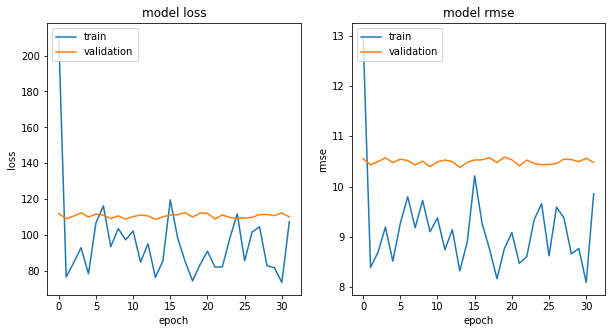

In [20]:
# plot
# Use matplotlib for visualising the model
import matplotlib.pyplot as plt
nrows = 1
ncols = 2
# The `.figure()` method will create a new figure, or activate an existing figure
fig = plt.figure(figsize=(10,5))

for idx, key in enumerate(["loss", "rmse"]):
    ax = fig.add_subplot(nrows, ncols, idx+1)
# The `.plot()` is a versatile function, and will take an arbitrary number of arguments
    plt.plot(history.history[key])
    plt.plot(history.history["val_{}".format(key)])
# The `.title()` method sets a title for the axes
    plt.title("model {}".format(key))
    plt.ylabel(key)
    plt.xlabel("epoch")
# The `.legend()` method will place a legend on the axes
    plt.legend(["train", "validation"], loc="upper left");

## Predict with the model locally

To predict with Keras, you simply call [model.predict()](https://keras.io/models/model/#predict) and pass in the cab ride you want to predict the fare amount for.

In [21]:
# Use the model to do prediction with `model.predict()`
model.predict({
    "pickup_longitude": tf.convert_to_tensor([-73.982683]),
    "pickup_latitude": tf.convert_to_tensor([40.742104]),
    "dropoff_longitude": tf.convert_to_tensor([-73.983766]),
    "dropoff_latitude": tf.convert_to_tensor([40.755174]),
    "passenger_count": tf.convert_to_tensor([3.0])
}, steps=1)

array([[11.363737]], dtype=float32)

Of course, this is not realistic, because we can't expect client code to have a model object in memory. We'll have to export our model to a file, and expect the client code to instantiate the model from that exported file.